In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import zipfile
import nltk 

%matplotlib inline

from datasets import Dataset, load_dataset
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Miscellaneous
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/oabas/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Collection and Exploration
We would be making use of 1 different datasets to train our model. 1 was gotten from the `Huggingface` dataset library while the other was gotten from `Kaggle`. Label Description:
0 : `Fake`, 1 : `Real`

## Noah-Gift Data

In [3]:
data_files = {"train": "news_articles.csv"}
dataset = load_dataset("noahgift/fake-news", data_files=data_files)

# Access the train and test split
train_data = dataset["train"]

# Convert the train split to a pandas DataFrame
df_noah = pd.DataFrame(train_data)

Found cached dataset csv (/Users/oabas/.cache/huggingface/datasets/noahgift___csv/noahgift--fake-news-62c59a179550f70c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 109.82it/s]


In [4]:
df_noah.head(3)

author                      published  \
0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   

                                               title  \
0  muslims busted they stole millions in govt ben...   
1  re why did attorney general loretta lynch plea...   
2  breaking weiner cooperating with fbi on hillar...   

                                                text language  \
0  print they should pay all the back all the mon...  english   
1  why did attorney general loretta lynch plead t...  english   
2  red state  \nfox news sunday reported this mor...  english   

              site_url                                       main_img_url  \
0  100percentfedup.com  http://bb4sp.com/wp-content/uploads/2016/10/Fu...   
1  100percentfedup.com  http://bb4sp.com/wp-content/uploads/2016/10/Fu...   
2  100percentfedup.com  http://bb4sp.com/wp-content/uploads/2016/10/Fu...   

   type label                            title_without_stopwords  \
0  bias  Real        muslims busted stole millions govt benefits   
1  bias  Real         attorney general loretta lynch plead fifth   
2  bias  Real  breaking weiner cooperating fbi hillary email ...   

                              text_without_stopwords  hasImage  
0  print pay back money plus interest entire fami...       1.0  
1  attorney general loretta lynch plead fifth bar...       1.0  
2  red state fox news sunday reported morning ant...       1.0

In [5]:
df_noah_train = df_noah[['title_without_stopwords', 'text_without_stopwords', 'type', 'label']]

# Rename the 'type' column to 'subject'
df_noah_train = df_noah_train.rename(columns={'type': 'subject', 'text_without_stopwords': 'text', 'title_without_stopwords' : 'title'})

df_noah_train.head(2)

title  \
0  muslims busted stole millions govt benefits   
1   attorney general loretta lynch plead fifth   

                                                text subject label  
0  print pay back money plus interest entire fami...    bias  Real  
1  attorney general loretta lynch plead fifth bar...    bias  Real

In [6]:
df_noah_train.shape

(2096, 4)

In [7]:
df_noah_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    2094 non-null   object
 1   text     2046 non-null   object
 2   subject  2095 non-null   object
 3   label    2095 non-null   object
dtypes: object(4)
memory usage: 65.6+ KB


In [8]:
# Checking for missing value
df_noah_train.isna().sum()

title       2
text       50
subject     1
label       1
dtype: int64

## Kaggle Dataset

In [9]:
# # https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

# with zipfile.ZipFile("/content/drive/MyDrive/Data_Science/FakeReal_News_detection/archive.zip", "r") as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Data_Science/FakeReal_News_detection/")

In [10]:
# df_true = pd.read_csv("/content/drive/MyDrive/Data_Science/FakeReal_News_detection/True.csv")
# df_fake = pd.read_csv("/content/drive/MyDrive/Data_Science/FakeReal_News_detection/Fake.csv")

In [11]:
# https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

with zipfile.ZipFile("../Data/archive.zip", "r") as zip_ref:
    zip_ref.extractall("../Data/")

In [12]:
df_true = pd.read_csv("../Data/True.csv")
df_fake = pd.read_csv("../Data/Fake.csv")

In [13]:
df_true.head(2)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017

In [14]:
# Adding A Target Class Column To Indicate Whether The News Is Real Or Fake
df_true['label'] = "Real"

In [15]:
df_fake.head(2)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017

In [16]:
# Adding A Target Class Column To Indicate Whether The News Is Real Or Fake
df_fake['label'] = "Fake"

In [17]:
# Concatenating Real And Fake News
df_kaggle_train = pd.concat([df_true, df_fake]).reset_index(drop = True)

# dropping the 'date' column
df_kaggle_train.drop(columns = ['date'], inplace = True)

df_kaggle_train.head(2)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject label  
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews  Real  
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews  Real

In [18]:
df_kaggle_train.nunique()

title      38729
text       38646
subject        8
label          2
dtype: int64

In [19]:
df_kaggle_train.shape

(44898, 4)

## Concatenating both datasets

In [20]:
# Concatenating Real And Fake News
df_train = pd.concat([df_noah_train, df_kaggle_train]).reset_index(drop = True)

df_train.head(2)

title  \
0  muslims busted stole millions govt benefits   
1   attorney general loretta lynch plead fifth   

                                                text subject label  
0  print pay back money plus interest entire fami...    bias  Real  
1  attorney general loretta lynch plead fifth bar...    bias  Real

In [21]:
df_train.shape

(46994, 4)

# Exploratory Data Analysis

In [22]:
df_train.head(2)

title  \
0  muslims busted stole millions govt benefits   
1   attorney general loretta lynch plead fifth   

                                                text subject label  
0  print pay back money plus interest entire fami...    bias  Real  
1  attorney general loretta lynch plead fifth bar...    bias  Real

## Label

In [23]:
df_train['label'].value_counts()

Fake    24775
Real    22218
Name: label, dtype: int64

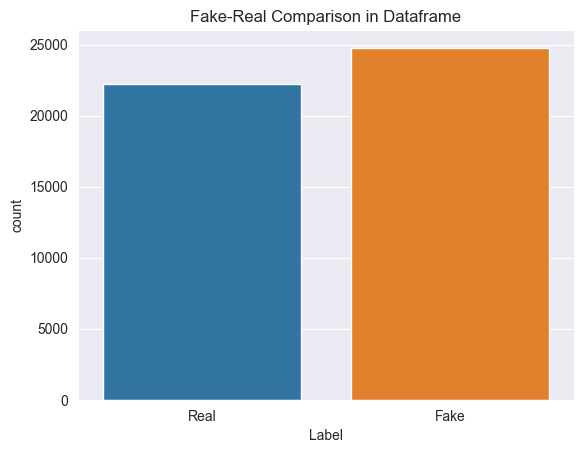

In [24]:
sns.set_style("darkgrid")
sns.countplot(x="label", data=df_train)

plt.title("Fake-Real Comparison in Dataframe")
plt.xlabel("Label")
plt.show()

## Subjects

In [25]:
df_train['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
bs                   601
bias                 436
conspiracy           430
hate                 244
satire               146
state                121
junksci              102
fake                  15
Name: subject, dtype: int64

In the context of your dataset, `bs`, `satire`, and `junksci` likely refer to the following:

1. `bs` is short for "bullshit", which is often used to describe misleading or false information.
2. `satire` refers to content that is intended to be humorous or mocking, often by using exaggeration or irony to make a point.
3. `junksci` is short for "junk science", which refers to information or research that is not based on sound scientific methods or principles.

Let's check for each thou

In [26]:
bs_data = df_train[df_train['subject'] == 'bs'][['title', 'text', 'label']]
bs_data.head()

title  \
59  clinton prides pig farm bridge serco zulu serv...   
60                                              title   
61                                              title   
62                                              title   
63                                              title   

                                                 text label  
59  rothschild banksters british voting machines r...  Fake  
60  problem usa constitution states congress decla...  Fake  
61  plenty proof machines rigged whic also means t...  Fake  
62  trump excuse audit vote machines trust un invo...  Fake  
63  got go one causing al trouble around worl proo...  Fake

In [27]:
bs_data = df_train[df_train['subject'] == 'junksci'][['title', 'text', 'label']]
bs_data.head()

title  \
865   geniuses schizophrenics pass question quiz dav...   
866   pomegranate pistachio pancakes david avocado w...   
1290  california becomes second state raise legal sm...   
1291  babies obese mothers high risk brain damage st...   
1292  nestle launch new nongmo products shocked mons...   

                                                   text label  
865   posted october michael depinto anyone heard ye...  Fake  
866   posted october paul joseph watson authorities ...  Fake  
1290  americas shrimp imports injected dangerous che...  Fake  
1291  superbugs big pharma blame coming death people...  Fake  
1292  contaminated food china entering us organic la...  Fake

Also, we can see from the `subject` unique columns that we have `politics` and `politicsNews` which is the could be under the same context.

In [28]:
# Transforming the unmatching subjects to the same notation
df_train['subject'] = df_train['subject'].replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

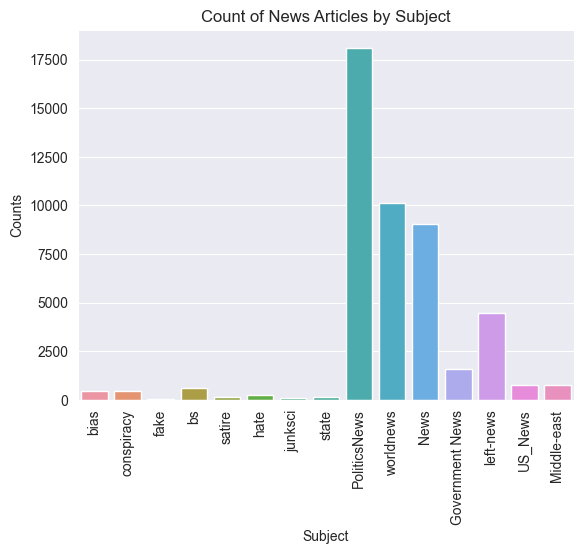

In [29]:
sns.set_style("darkgrid")
sns.countplot(x="subject", data=df_train)

plt.title("Count of News Articles by Subject")
plt.xlabel("Subject")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.show()

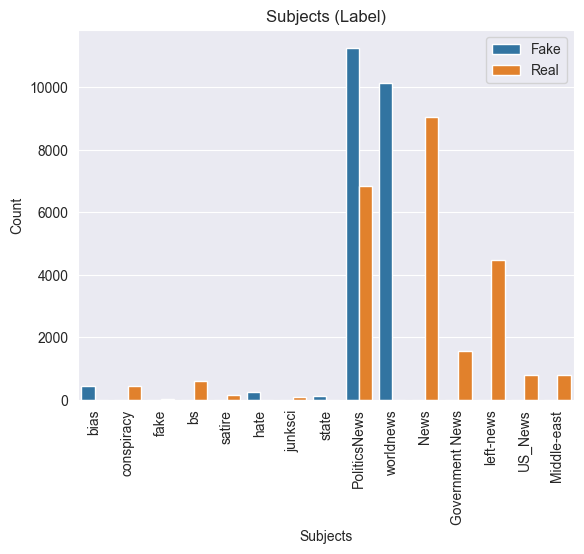

In [30]:
sns.countplot(x="subject", hue="label", data=df_train)

plt.title("Subjects (Label)")
plt.xlabel("Subjects")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake", "Real"], loc="best")
plt.show()

# Data Preprocessing

In [31]:
# Combining Title And Text Together
df_train['original'] = df_train['title'] + '. ' + df_train['text']
df_train.head()

title  \
0        muslims busted stole millions govt benefits   
1         attorney general loretta lynch plead fifth   
2  breaking weiner cooperating fbi hillary email ...   
3  pin drop speech father daughter kidnapped kill...   
4  fantastic trumps point plan reform healthcare ...   

                                                text subject label  \
0  print pay back money plus interest entire fami...    bias  Real   
1  attorney general loretta lynch plead fifth bar...    bias  Real   
2  red state fox news sunday reported morning ant...    bias  Real   
3  email kayla mueller prisoner tortured isis cha...    bias  Real   
4  email healthcare reform make america great sin...    bias  Real   

                                            original  
0  muslims busted stole millions govt benefits. p...  
1  attorney general loretta lynch plead fifth. at...  
2  breaking weiner cooperating fbi hillary email ...  
3  pin drop speech father daughter kidnapped kill...  
4  fantastic trumps point plan reform healthcare ...

In [32]:
# Checking for duplicated in the news dataset
df_train.duplicated().sum()

270

In [33]:
# Dropping the duplicated in the news dataset
df_train.drop_duplicates(inplace=True)

In [34]:
# # Dropping columns not to be used
# df_train.drop(['title', 'text', 'subject'],axis=1,inplace=True)

# Checking for missing values
df_train.isna().sum()

title        2
text        33
subject      1
label        1
original    34
dtype: int64

In [35]:
# dropping missing columns
df_train.dropna(inplace=True)
df_train.shape

(46690, 5)

# Text Preprocessing

In [36]:
news = list(df_train['original'])
len(news)

46690

## Lowering the text

* It is one of the most common text preprocessing Python steps where the text is converted into the same case preferably lower case.
* But it is not necessary to do this step every time you are working on an NLP problem as for some problems lower casing can lead to loss of information.

In [37]:
news = [c.lower() for c in tqdm(news)]

100%|█████████████████████████████████| 46690/46690 [00:00<00:00, 272033.92it/s]


## Tokenization

* In this step, the text is split into smaller units.
* We can use either sentence tokenization or word tokenization based on our problem statement.

In [38]:
# Tokenize the text
tokens = [word_tokenize(c) for c in tqdm(news)]

100%|████████████████████████████████████| 46690/46690 [00:46<00:00, 994.87it/s]


## Stop words removal

`Stopwords` are the commonly used words and are removed from the text as they do not add any value to the analysis. The `NLTK library` provides a predefined set of stop words that are commonly used in the English language. These stop words are usually common words that do not add much meaning to the text and are therefore removed during text preprocessing to reduce the size of the text corpus and improve the performance of the machine learning algorithm. However, sometimes, these predefined stop words may not be sufficient for a specific task that was why I decided to add additional stopwords to the list.

In [39]:
# Obtaining Additional Stopwords From nltk
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [40]:
# Remove Stop-words
tokens = [[word for word in t if word not in stop_words]
          for t in tqdm(tokens)]

100%|███████████████████████████████████| 46690/46690 [00:14<00:00, 3136.95it/s]


## Lemmatization
`Lemmatization` is a NLP technique that involves reducing words to their base or dictionary form, which is known as the lemma. For example, the lemma of the word `running` is `run`, and the lemma of the word `mice` is `mouse`. It aims to group together related forms of a word, so that they can be analyzed as a single item.

`Lemmatization` is different from `stemming`, which involves simply removing the suffixes from words to obtain their root form. For example, the stem of the word "running" is "runn", and the stem of the word "mice" is "mic". Stemming is a simpler and faster technique than lemmatization, but it can result in incorrect root forms in some cases.

In [41]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
tokens = [[lemmatizer.lemmatize(word) for word in t] for t in tqdm(tokens)]

100%|███████████████████████████████████| 46690/46690 [00:19<00:00, 2342.03it/s]


## Removing punctuation

* In this step all the punctuations from the text are removed.
* String library of Python contains some pre-defined list of punctuations such as ‘!”#$%&'()*+,-./:;?@[]^_`{|}~’

In [42]:
# Remove Punctuation marks
tokenizer = RegexpTokenizer(r'\w+')
tokens = [["".join(tokenizer.tokenize(word)) for word in t
           if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

100%|███████████████████████████████████| 46690/46690 [00:06<00:00, 7153.37it/s]


In [43]:
df_train["clean_tokens"] = tokens

## Word count distribution

In [44]:
flat_tokens = []
for t in tokens:
    for word in t:
        flat_tokens.append(word)

In [45]:
len(flat_tokens)

11438639

In [78]:
# Obtaining The Total Number Of Unique Words
unique_words = len(list(set(flat_tokens)))
unique_words

222923

In [46]:
# unique tokens
counts = Counter(flat_tokens)
len(counts)

222923

In [47]:
# most common tokes
counts.most_common(10)

[('trump', 146510),
 ('said', 131495),
 ('state', 61464),
 ('would', 57311),
 ('president', 55952),
 ('us', 51901),
 ('people', 44243),
 ('republican', 40702),
 ('one', 39949),
 ('year', 35402)]

In [48]:
# Checking for unique tokens in the whole dataset
counter = Counter([t for news in tqdm(tokens) for t in news])

100%|█████████████████████████████████| 46690/46690 [00:00<00:00, 119681.04it/s]


In [49]:
counter.most_common(10)

[('trump', 146510),
 ('said', 131495),
 ('state', 61464),
 ('would', 57311),
 ('president', 55952),
 ('us', 51901),
 ('people', 44243),
 ('republican', 40702),
 ('one', 39949),
 ('year', 35402)]

In [50]:
print(f"We have {len(counter.keys())} unique tokens in the dataset")

We have 222923 unique tokens in the dataset


In [51]:
clean_text = [" ".join(news) for news in tqdm(tokens)]

100%|█████████████████████████████████| 46690/46690 [00:00<00:00, 138559.96it/s]


In [52]:
tokens[20]

['mark',
 'cuban',
 'event',
 'donald',
 'win',
 'doubt',
 'market',
 'tanksso',
 'here',
 'really',
 'happened',
 'video',
 'percentfedupcom',
 'david',
 'wilcox',
 'year',
 'old',
 'chicago',
 'man',
 'brutally',
 'beaten',
 'mob',
 'black',
 'democrat',
 'asks',
 'happened',
 'america',
 'sad',
 'story']

In [53]:
clean_text[20]

'mark cuban event donald win doubt market tanksso here really happened video percentfedupcom david wilcox year old chicago man brutally beaten mob black democrat asks happened america sad story'

In [54]:
df_train['original'][20]

'mark cuban event donald wins doubt market tanksso heres really happened video percentfedupcom. david wilcox year old chicago man brutally beaten mob black democrats asks happened america sad story'

In [55]:
# Joining The Words Into A String
df_train["clean_text"] = clean_text
df_train.head(2)

title  \
0  muslims busted stole millions govt benefits   
1   attorney general loretta lynch plead fifth   

                                                text subject label  \
0  print pay back money plus interest entire fami...    bias  Real   
1  attorney general loretta lynch plead fifth bar...    bias  Real   

                                            original  \
0  muslims busted stole millions govt benefits. p...   
1  attorney general loretta lynch plead fifth. at...   

                                        clean_tokens  \
0  [muslim, busted, stole, million, govt, benefit...   
1  [attorney, general, loretta, lynch, plead, fif...   

                                          clean_text  
0  muslim busted stole million govt benefit print...  
1  attorney general loretta lynch plead fifth att...

## Visualizing Cleaned Up Dataset

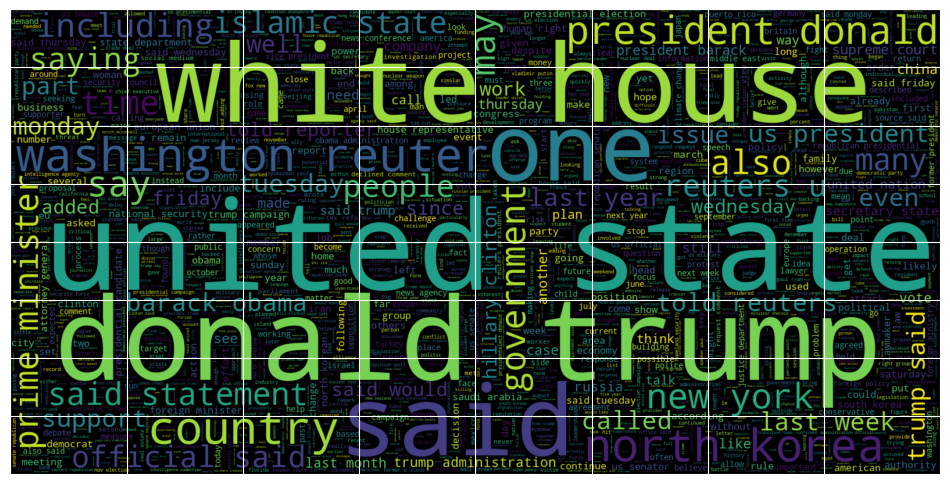

In [56]:
# Plotting The Word Cloud For Text That Is Real
plt.figure(figsize = (12,12))

wc = WordCloud(max_words = 2000,
               width = 1600,
               height = 800,
               stopwords = stop_words).generate(" ".join(df_train[df_train["label"] == "Real"].clean_text))

plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(wc, interpolation = "bilinear");

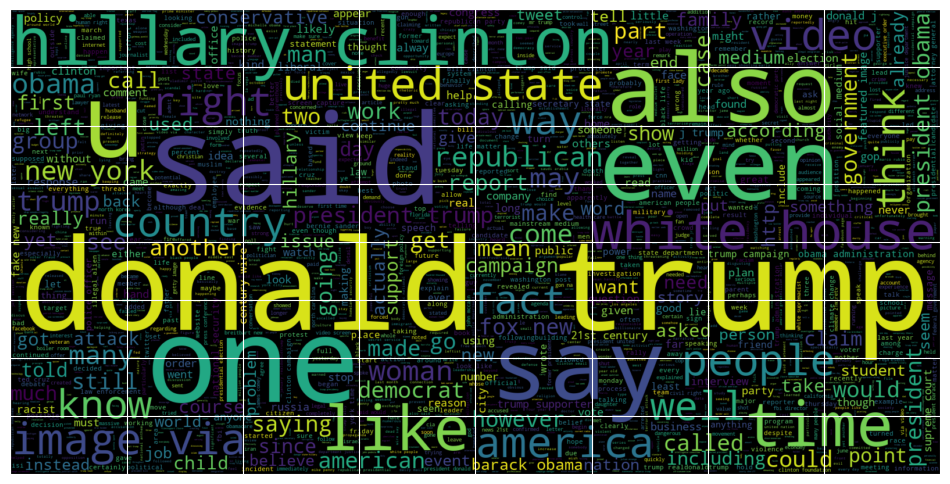

In [57]:
# Plotting The Word Cloud For Text That Is Fake
plt.figure(figsize = (12,12))

wc = WordCloud(max_words = 2000,
               width = 1600,
               height = 800,
               stopwords = stop_words).generate(" ".join(df_train[df_train["label"] == "Fake"].clean_text))

plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(wc, interpolation = "bilinear");

----

In [58]:
# Determining The Maximum Number Of Words In Any Document Required To Create Word Embeddings 
maxlen = -1
for doc in df_train.clean_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print(f"The maximum number of words in any document is = {maxlen}")

The maximum number of words in any document is = 4937


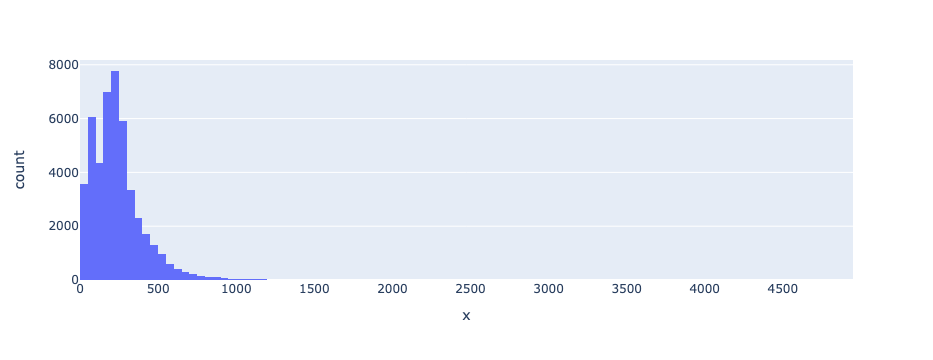

In [59]:
# Visualizing The Distribution Of Number Of Words In A Text
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df_train.clean_text], nbins = 100)
fig.show()

# Vectorization

In [60]:
vect = CountVectorizer()

X_countvect = vect.fit_transform(clean_text)
X_countvect.shape

(46690, 222881)

In [61]:
vectorizer = TfidfVectorizer(min_df = 50, max_features = 10000)

X_tfidvect =  vectorizer.fit_transform(clean_text)
X_tfidvect.shape

(46690, 10000)

In [62]:
y = df_train['label']

## Train | Test Split

In [63]:
# Instantiate the LabelEncoder object
le = LabelEncoder()

# Fit and transform the target variable
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_countvect, y, test_size=0.2, stratify=y, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidvect, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (37352, 222881)
X_test: (9338, 222881)
y_train: (37352,)
y_test: (9338,)


In [64]:
print(f"X_train: {X_train1.shape}")
print(f"X_test: {X_test1.shape}")
print(f"y_train: {y_train1.shape}")
print(f"y_test: {y_test1.shape}")

X_train: (37352, 10000)
X_test: (9338, 10000)
y_train: (37352,)
y_test: (9338,)


In [65]:
# Tf-id Vectorizer
selector = SelectKBest(score_func=f_classif,k=7)
X_train1 = selector.fit_transform(X_train1,y_train1)
X_test1 = selector.fit_transform(X_test1,y_test1)

# Machine Learning

In [66]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()

## Supervised Learning

In [67]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Extreme Gradient Boosting": XGBClassifier()
}

# Creating a function to fit and score the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [68]:
model_scores = fit_and_score(models=models,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)
model_scores

/Users/oabas/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'Logistic Regression': 0.9826515313771685,
 'Random Forest': 0.9765474405654315,
 'Naive Bayes': 0.9435639323195545,
 'Gradient Boosting Classifier': 0.9849004069393874,
 'Decision Tree Classifier': 0.9837224245020347,
 'Extreme Gradient Boosting': 0.9883272649389591}

In [69]:
model_scores = fit_and_score(models=models,
                            X_train=X_train1,
                            X_test=X_test1,
                            y_train=y_train1,
                            y_test=y_test1)
model_scores

{'Logistic Regression': 0.943992289569501,
 'Random Forest': 0.9790104947526237,
 'Naive Bayes': 0.9065110301991861,
 'Gradient Boosting Classifier': 0.9790104947526237,
 'Decision Tree Classifier': 0.9734418505033198,
 'Extreme Gradient Boosting': 0.9807239237524095}

**`Countvectorizer` gave the best accuracy, I would focus more on `ExtremeGB` as the it gave the highest score**

----

In [70]:
# Extreme Gradient Boosting
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict on the test data
test_pred = xgb_model.predict(X_test)

# Classification report for training data
categories=['real','fake']

print("Extreme Gradient Boosting")
print(f"Accuracy on test set: {accuracy_score(y_test, test_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, test_pred)}")
print(f"Classification report:\n{classification_report(y_test, test_pred, target_names=categories, digits=4)}\n")

Extreme Gradient Boosting
Accuracy on test set: 0.9883272649389591
Confusion matrix:
[[4922   24]
 [  85 4307]]
Classification report:
              precision    recall  f1-score   support

        real     0.9830    0.9951    0.9890      4946
        fake     0.9945    0.9806    0.9875      4392

    accuracy                         0.9883      9338
   macro avg     0.9887    0.9879    0.9883      9338
weighted avg     0.9884    0.9883    0.9883      9338




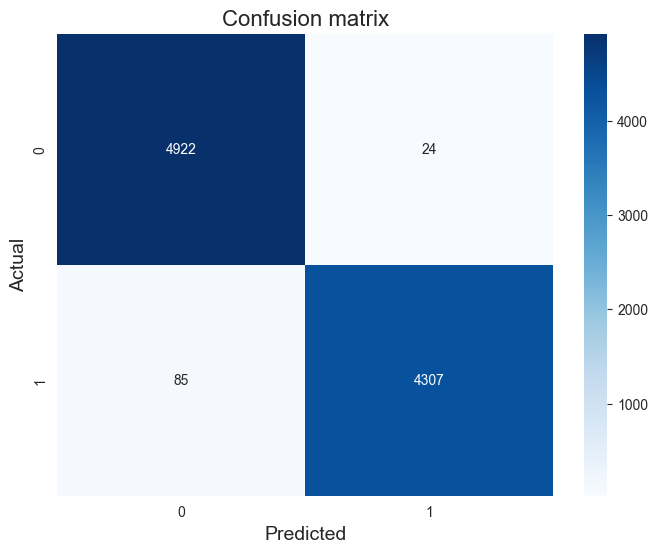

In [71]:
# Pass the trained model, test data and labels to the function
plot_confusion_matrix(xgb_model, X_test, y_test)

# Deep Learning

In [83]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

## Preparing The Data By Performing Tokenization And Padding

In [86]:
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
X_train, X_test, y_train, y_test = train_test_split(df_train['clean_text'], df_train['label'], test_size=0.2, random_state=42)


# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = unique_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure that they are of the same length
padded_train = pad_sequences(train_sequences, maxlen = maxlen, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = maxlen, truncating = 'post')

In this code, I used `Keras' Tokenizer` function to tokenize the text in my dataset and create sequences of tokenized words. To do this, I first set the maximum number of words to be used to be equal to the total number of unique words in my dataset. Then, I created a `tokenizer` and fit it to the text in the `clean_text` column of my dataframe, which assigns a unique integer to each word in the text. I then used the tokenizer's `texts_to_sequences` method to convert my tokenized text into sequences of integers. To ensure that all sequences are of the same length, I used Keras' **pad_sequences** function to pad the sequences with zeros or truncate them as necessary. Finally, I split my data into training and testing sets using scikit-learn's `train_test_split` function.

## Building And Training The Model

In [90]:
# Sequential Model
model = Sequential()

# Embeddidng layer
model.add(Embedding(unique_words, output_dim = 128))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         28534144  
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 28,830,337
Trainable params: 28,830,337
Non-trainable params: 0
_________________________________________________________________


In [91]:
y_train = np.asarray(y_train)

# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

Epoch 1/5
526/526 [==============================] - 52s 95ms/step - loss: 0.0815 - acc: 0.9704 - val_loss: 0.0297 - val_acc: 0.9914
Epoch 2/5
526/526 [==============================] - 46s 87ms/step - loss: 0.0127 - acc: 0.9962 - val_loss: 0.0341 - val_acc: 0.9898
Epoch 3/5
526/526 [==============================] - 45s 86ms/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0411 - val_acc: 0.9898
Epoch 4/5
526/526 [==============================] - 44s 83ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0395 - val_acc: 0.9896
Epoch 5/5
526/526 [==============================] - 43s 82ms/step - loss: 5.3648e-04 - acc: 0.9999 - val_loss: 0.0577 - val_acc: 0.9898


## Assessing Trained Model Performance

* accuracy_score
* confusion_matrix
* classification_report

In [94]:
# Predict on test data
pred = model.predict(padded_test)

292/292 [==============================] - 4s 10ms/step


In [95]:
# If The Predicted Value Is > 0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

In [97]:
# Print accuracy score
accuracy = accuracy_score(list(y_test), prediction)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 98.82%


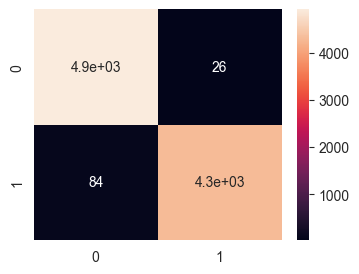

In [100]:
# Getting The Confusion Matrix
conf = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (12, 8))
sns.heatmap(conf, annot = True)
plt.show()

In [98]:
# Classification report for training data
categories=['Real','Fake']

# Print classification report
class_report = classification_report(list(y_test), prediction, target_names=categories, digits=2)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4946
           1       0.99      0.98      0.99      4392

    accuracy                           0.99      9338
   macro avg       0.99      0.99      0.99      9338
weighted avg       0.99      0.99      0.99      9338

